In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import statsmodels.stats.proportion as sp
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV

In [3]:
df = pd.read_csv("online_shoppers_intention.csv")
df.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
2688,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,May,3,2,4,2,Returning_Visitor,True,False
10328,0,0.0,0,0.0,22,348.433333,0.028571,0.041270,0.0,0.0,Nov,1,8,6,11,Returning_Visitor,False,True
1482,1,85.0,0,0.0,14,306.500000,0.000000,0.004444,0.0,0.0,Mar,2,2,3,2,Returning_Visitor,False,False
10830,0,0.0,0,0.0,6,192.083333,0.044444,0.035556,0.0,0.0,Nov,3,2,1,2,Returning_Visitor,False,False
3887,0,0.0,0,0.0,3,313.000000,0.000000,0.033333,0.0,0.0,May,2,10,5,4,Returning_Visitor,True,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [ ]:
# Tambahan Budi
df.describe()

In [5]:
nums = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

cats = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month', 
        'VisitorType', 'Weekend', 'Revenue']

In [6]:
y = df['Revenue']
X = df.drop(['Revenue'], axis = 1)
X_nums = df[nums]
X_cats = df[cats].drop(['Revenue'], axis = 1)

## Pre-Processing

In [10]:
# Train-Test Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 42)

In [11]:
# Endoding Function
def ordinal_encode(data, column, order):
    data = data.copy()
    data[column] = data[column].apply(lambda x: order.index(x))
    return data

def onehot_encode(data, column, prefix):
    data = data.copy()
    dummies = pd.get_dummies(data[column], prefix=prefix)
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column, axis=1)
    return data

In [12]:
month_order = ["Jan","Feb", "Mar", "Apr", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

X_train = ordinal_encode(X_train, 'Month', month_order)

X_train = onehot_encode(X_train, 'VisitorType', 'visitor')

## Feature Selection

### Via Variance Threshold

In [15]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [17]:
selected = variance_threshold_selector(X_train)
selected.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'PageValues', 'Month', 'OperatingSystems', 'Browser', 'Region',
       'TrafficType'],
      dtype='object')

*Berdasarkan variance threshold selector, fitur yang diseleksi adalah SEMUA FITUR KECUALI:*
1. BounceRates
2. ExitRates
3. SpecialDay
4. Weekend
5. visitor_New_Visitor
6. visitor_Other
7. visitor_Returning_Visitor

### Univariate Feature Selection (Scoring Function = chi2)

In [33]:
# Create and fit selector
selector = SelectKBest(chi2, k=8)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X_train.iloc[:,cols]
X_new.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'PageValues', 'Month'],
      dtype='object')

*Berdasarkan K-Best selector (scoring function = chi2), 8 fitur yang diseleksi adalah:*
1. Administrative
2. Administrative_Duration
3. Informational
4. Informational_Duration
5. ProductRelated
6. ProductRelated_Duration
7. PageValues
8. Month

### Univariate Feature Selection (Scoring Function = mutual_info_classif)

In [36]:
# Create and fit selector
selector = SelectKBest(mutual_info_classif, k=8)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X_train.iloc[:,cols]
X_new.columns

Index(['Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Month', 'TrafficType'],
      dtype='object')

*Berdasarkan K-Best selector (scoring function = mutual_info_classif), 8 fitur yang diseleksi adalah:*
1. Administrative_Duration
2. ProductRelated
3. ProductRelated_Duration
4. BounceRates
5. ExitRates
6. PageValues
7. Month
8. TrafficType

### Model-based Feature Selection (Feature Importances)

Text(0.5, 1.0, 'Feature importances via coefficients')

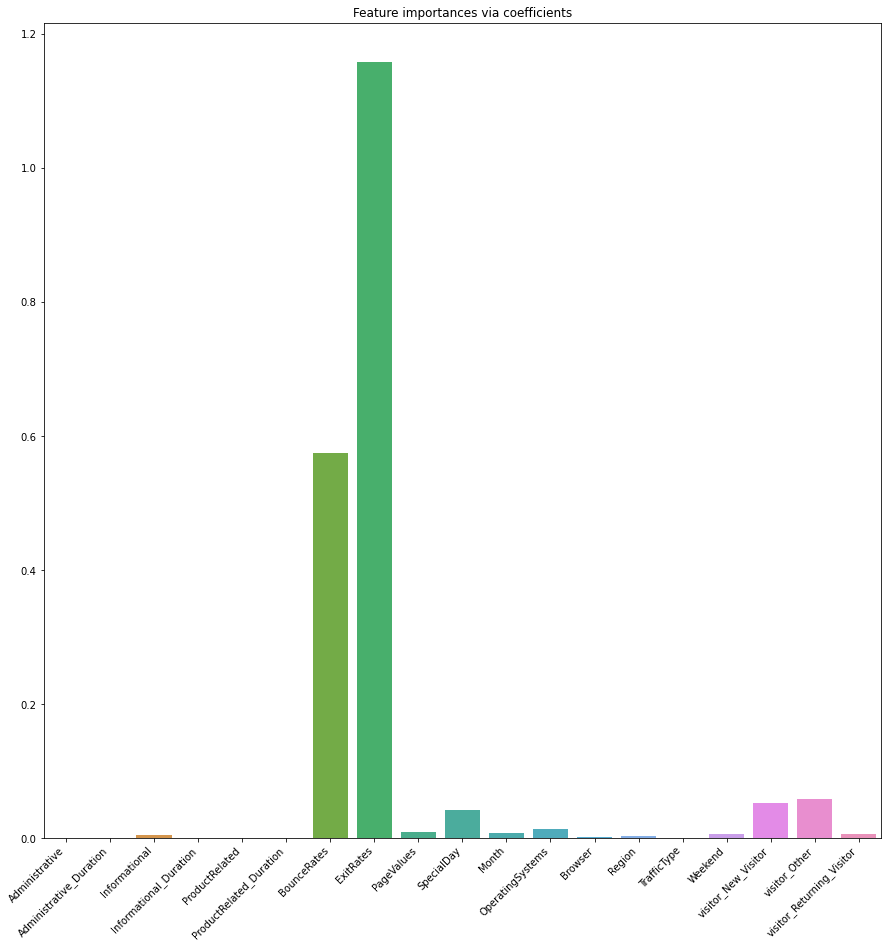

In [55]:
# Menghitung feature importance dari koefisien ridge (estimator = RidgeCV)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
feature_names = np.array(X_train.columns)
# plot feature importance
fig,ax = plt.subplots(figsize=(15,15))
ax = sns.barplot(y=importance, x=feature_names)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Feature importances via coefficients")

In [60]:
from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-6] + 0.01
sfm = SelectFromModel(ridge, threshold=threshold).fit(X_train, y_train)

print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: ['BounceRates' 'ExitRates' 'SpecialDay' 'visitor_New_Visitor'
 'visitor_Other']


*Berdasarkan feature importance, fitur yang diseleksi ialah (5 fitur dengan importance tertinggi descending):*
1. BounceRates
2. ExitRates
3. SpecialDay
4. visitor_New_Visitor
5. visitor_Other

## Feature Extraction

In [61]:
df['Sum_VisitedPages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']
df['Sum_Duration'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']

## Ide Fitur Tambahan di luar Dataset

1. Product_in_Cart
2. Promo_Taken
3. Membership
4. Review_Given